In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report

In [7]:
# Step 1: Load data
df = pd.read_excel("Sam's_Fans_All_Transactions_All_Time.xlsx", parse_dates=["Date"])

# Step 2: Sort and engineer features
df.sort_values(by=["Account Number", "Date"], inplace=True)

# Step 3: Create features: total donations, recency, frequency
feature_df = df.groupby("Account Number").agg({
    "Date": ["min", "max", "count"], 
    "Revenue Amount": "sum"
})
feature_df.columns = ['first_donation', 'last_donation', 'frequency', 'total_amount']
feature_df['recency_days'] = (df['Date'].max() - feature_df['last_donation']).dt.days

# Step 4: Create label: did donor donate again within 90 days after a donation
retention_labels = []
for acc in df['Account Number'].unique():
    dates = df[df["Account Number"] == acc]["Date"].sort_values().tolist()
    retained = 0
    for i in range(len(dates) - 1):
        if (dates[i+1] - dates[i]).days <= 90:
            retained = 1
            break
    retention_labels.append(retained)

feature_df['retained'] = retention_labels

# Step 5: Prepare model data
X = feature_df[["frequency", "total_amount", "recency_days"]]
y = feature_df["retained"]

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train model
model = XGBClassifier(eval_metric='logloss')  # Removed use_label_encoder to fix warning
model.fit(X_train, y_train)

# Step 8: Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       407
           1       0.84      0.80      0.82       116

    accuracy                           0.92       523
   macro avg       0.89      0.88      0.88       523
weighted avg       0.92      0.92      0.92       523



<Figure size 800x600 with 0 Axes>

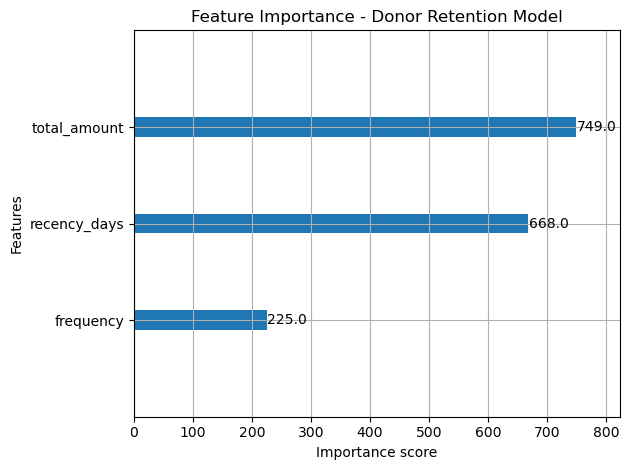

In [4]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(8, 6))
plot_importance(model)
plt.title("Feature Importance - Donor Retention Model")
plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred already exist
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])  # [[TN, FP], [FN, TP]]

# Extract values
tn, fp, fn, tp = cm.ravel()

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")


True Positives (TP): 93
False Positives (FP): 18
False Negatives (FN): 23
True Negatives (TN): 389


In [6]:
def calculate_metrics(TP, TN, FP, FN):
    # Sensitivity: True Positive Rate = TP / (TP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Specificity: True Negative Rate = TN / (TN + FP)
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    return sensitivity, specificity

sensitivity, specificity = calculate_metrics(tp, tn, fp, fn)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")


Sensitivity: 0.80
Specificity: 0.96
